# Rat RNN

### Load Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf

from unityagents import UnityEnvironment

%matplotlib inline

### Hyperparameters

In [2]:
learning_rate = 1e-4
weights_regularization = 100.0
act_regularization = 1.0
hidden_units = 96
train_steps = 1000
ep_length = 500
sim_steps = 1000000
batch_size = 256

noise_stddev = 0.05

x_size = 7

model_path = 'rat_model'
data_path = 'rat_data_large'

## Generate Data
Prerequisite: Load unity project in the Editor. Build and save executable as "rat.exe" or "rat.app".

### Start Environment

In [ ]:
env_name = "rat" # Name of the Unity environment binary to launch
env = UnityEnvironment(file_name=env_name, worker_id=1)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]

### Collect States

In [ ]:
x,z,ep = [], [], []
input_x = []
a = env.reset()[default_brain]
for i in range(sim_steps - 1):
    
    # check for NANs
    if a.states[0].dtype != np.float64:
        print(i, a.states[0].dtype, a.states[0])
    elif np.any(np.isnan(a.states[0])):
        print(i, "NAN", a.states[0])
        
    # append
    x.append(a.states[0][0])
    z.append(a.states[0][1])
    input_x.append(a.states[0][2:-1])
    ep.append(a.states[0][-1])

    # next simulation step
    a = env.step()[default_brain]

    if i % (sim_steps/10) == 0 and i != 0:
        print(i)

In [ ]:
x = np.array(x)
z = np.array(z)
input_x = np.array(input_x)
input_y = np.stack((x, z), axis=1)

### Save Training Data

In [ ]:
if not os.path.exists(data_path):
    os.makedirs(data_path)

save_data = {"x": input_x, "y": input_y}
pickle.dump(save_data, open(data_path+"/data.p", "wb"))

## Load Training Data

In [3]:
save_data = pickle.load(open(data_path+"/data.p", "rb"))
input_x = save_data["x"]
input_y = save_data["y"]
x = input_y[:, 0]
z = input_y[:, 1]

In [4]:
print(np.shape(input_x))

(1000000, 7)


### Visualize Rat Trajectory

In [ ]:
def create_colors(length, segments):
    c_list = []
    for i in range(segments):
        color = np.zeros([length//segments, 4])
        color[:, 3] = 0.5
        color[:, 0:3] = np.random.uniform(0, 1, size=[1, 3])
        c_list.append(color)
    c_list = np.reshape(c_list, [length, 4])
    return c_list

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(x, z, s=1, c=create_colors(sim_steps, sim_steps//ep_length))
plt.ylim(-4.5, 4.5)
plt.xlim(-4.5, 4.5)

In [ ]:
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.ylim(-4.5, 4.5)
    plt.xlim(-4.5, 4.5)
plt.show()

## Rat RNN

### Define Network

In [5]:
class _Linear(object):
  """Linear map: sum_i(args[i] * W[i]), where W[i] is a variable.
  """
  def __init__(self,
               args,
               output_size,
               build_bias,
               bias_initializer=None,
               kernel_initializer=None):
    self._build_bias = build_bias

    if args is None or (tf.contrib.framework.nest.is_sequence(args) and not args):
      raise ValueError("`args` must be specified")
    if not tf.contrib.framework.nest.is_sequence(args):
      args = [args]
      self._is_sequence = False
    else:
      self._is_sequence = True

    # Calculate the total size of arguments on dimension 1.
    total_arg_size = 0
    shapes = [a.get_shape() for a in args]
    for shape in shapes:
      if shape.ndims != 2:
        raise tf.ValueError("linear is expecting 2D arguments: %s" % shapes)
      if shape[1].value is None:
        raise tf.ValueError("linear expects shape[1] to be provided for shape %s, "
                         "but saw %s" % (shape, shape[1]))
      else:
        total_arg_size += shape[1].value

    dtype = [a.dtype for a in args][0]

    scope = tf.get_variable_scope()
    with tf.variable_scope(scope) as outer_scope:
      self._weights = tf.get_variable(
          "kernel", [total_arg_size, output_size],
          dtype=dtype,
          initializer=kernel_initializer)
      if build_bias:
        with tf.variable_scope(outer_scope) as inner_scope:
          inner_scope.set_partitioner(None)
          if bias_initializer is None:
            bias_initializer = tf.constant_initializer(0.0, dtype=dtype)
          self._biases = tf.get_variable(
              "bias", [output_size],
              dtype=dtype,
              initializer=bias_initializer)

  def __call__(self, args):
    if not self._is_sequence:
      args = [args]

    if len(args) == 1:
      res = tf.matmul(args[0], self._weights)
    else:
      res = tf.matmul(tf.concat(args, 1), self._weights)
    if self._build_bias:
      res = tf.nn.bias_add(res, self._biases)
    return res


class MyBasicLSTMCell(tf.contrib.rnn.RNNCell):
  def __init__(self, num_units, forget_bias=1.0,
               activation=None, reuse=None):
    super(MyBasicLSTMCell, self).__init__(_reuse=reuse)
    self._num_units = num_units
    self._forget_bias = forget_bias
    self._activation = activation or tf.nn.tanh
    self._linear = None

  @property
  def state_size(self):
    return (tf.contrib.rnn.LSTMStateTuple(self._num_units, self._num_units))

  @property
  def output_size(self):
    return self._num_units

  def call(self, inputs, state):
    sigmoid = tf.sigmoid
    c, h = state

    if self._linear is None:
      self._linear = _Linear([inputs, h], 4 * self._num_units, True)
    # i = input_gate, j = new_input, f = forget_gate, o = output_gate
    i, j, f, o = tf.split(
        value=self._linear([inputs, h]), num_or_size_splits=4, axis=1)

    new_c = (
        c * sigmoid(f + self._forget_bias) + sigmoid(i) * self._activation(j))
    new_h = self._activation(new_c) * sigmoid(o)
    new_h = tf.add(new_h,
                   tf.random_normal(shape=tf.shape(new_h), mean=0.0, stddev=noise_stddev, dtype=tf.float32))

    new_state = tf.contrib.rnn.LSTMStateTuple(new_c, new_h)
    return new_h, new_state

In [6]:
class RatRNN(object):
    def __init__(self, x_size, y_size, h_size, lr):
        self.x = tf.placeholder(shape=[None, x_size], dtype=tf.float32)
        self.train_length = tf.placeholder(shape=[1], dtype=tf.int32)
        self.batch_size = tf.placeholder(shape=[1], dtype=tf.int32)

        self.rnn_in = tf.reshape(self.x, shape=[self.batch_size[0], self.train_length[0], x_size])

        cell = MyBasicLSTMCell(h_size)
        self.state_in = cell.zero_state(self.batch_size[0], tf.float32)

        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(inputs=self.rnn_in, cell=cell, dtype=tf.float32,
                                                     initial_state=self.state_in)
        
        self.output = tf.reshape(self.rnn, shape=[-1, h_size])  
        
        self.y_pred = tf.layers.dense(self.output, y_size, activation=None)

        self.y = tf.placeholder(shape=[None, y_size], dtype=tf.float32)
        
        lossL2A = tf.nn.l2_loss(self.output)
        
        lossL2W = tf.add_n([ tf.nn.l2_loss(v) for v in tf.trainable_variables()
                           if 'bias' not in v.name ])

        self.weights_loss = lossL2W * weights_regularization
        self.act_loss = lossL2A * act_regularization
        self.regress_loss = tf.reduce_sum(tf.squared_difference(self.y, self.y_pred))
        self.loss = self.regress_loss + self.weights_loss + self.act_loss

        self.loss = tf.Print(self.loss, [lossL2A, lossL2W, self.regress_loss])

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update = optimizer.minimize(self.loss)

In [7]:
tf.reset_default_graph()
rat_rnn = RatRNN(x_size, 2, hidden_units, learning_rate)
sess = tf.InteractiveSession()
saver = tf.train.Saver()

### Train Network

500 2000.0


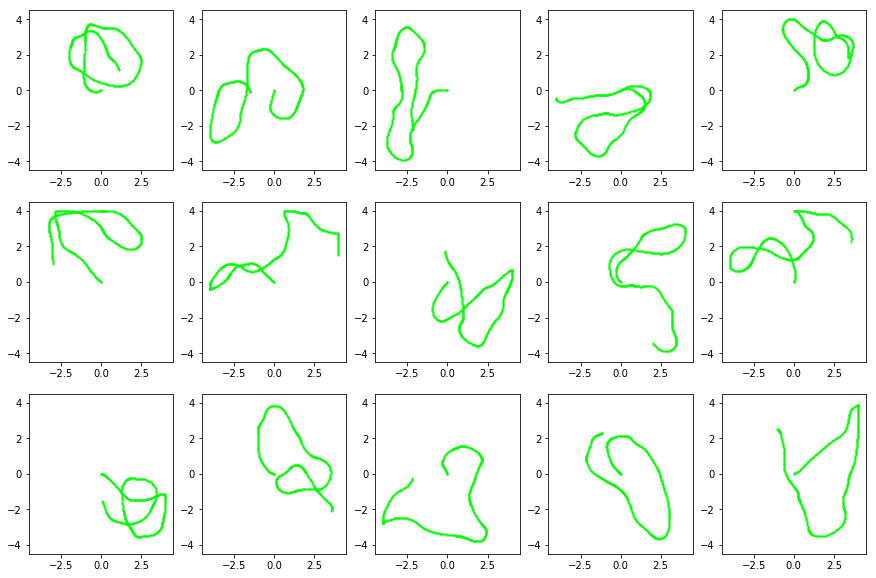

In [8]:
losses = []
init = tf.global_variables_initializer()
sess.run(init)
print(ep_length, sim_steps/ep_length)

# center training data
input_Y = np.copy(input_y)
for i in range(sim_steps//ep_length):
    pointer = i
    input_Y[pointer*ep_length:(pointer+1)*ep_length] -= input_Y[pointer*ep_length]

# debug viz
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_y = input_Y[pointer*ep_length:(pointer+1)*ep_length]
    
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.ylim(-4.5, 4.5)
    plt.xlim(-4.5, 4.5)
plt.show()

Loss: 281107.125 -- 1
Loss: 275971.53125 -- 2
Loss: 267537.1875 -- 3
Loss: 262292.96875 -- 4
Loss: 258795.75 -- 5
Loss: 241815.28125 -- 6
Loss: 242788.75 -- 7
Loss: 235225.84375 -- 8
Loss: 232345.78125 -- 9
Loss: 230392.8125 -- 10
Loss: 225787.75 -- 11
Loss: 220070.71875 -- 12
Loss: 215560.15625 -- 13
Loss: 216409.109375 -- 14
Loss: 209592.78125 -- 15
Loss: 209728.59375 -- 16
Loss: 206722.4375 -- 17
Loss: 205433.875 -- 18
Loss: 208938.734375 -- 19
Loss: 207059.296875 -- 20
Loss: 202829.71875 -- 21
Loss: 200604.40625 -- 22
Loss: 196941.3125 -- 23
Loss: 194152.734375 -- 24
Loss: 193405.0625 -- 25
Loss: 191896.96875 -- 26
Loss: 191101.21875 -- 27
Loss: 183507.578125 -- 28
Loss: 190357.75 -- 29
Loss: 185156.078125 -- 30
Loss: 177729.703125 -- 31
Loss: 185119.0625 -- 32
Loss: 180055.46875 -- 33
Loss: 184438.5 -- 34
Loss: 178605.8125 -- 35
Loss: 180565.078125 -- 36
Loss: 182506.15625 -- 37
Loss: 176993.046875 -- 38
Loss: 176889.375 -- 39
Loss: 175782.703125 -- 40
Loss: 177276.75 -- 41
Loss: 

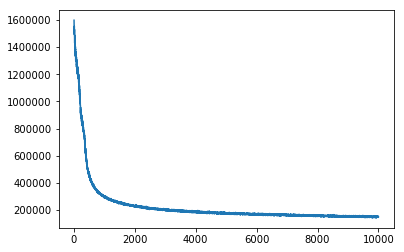

In [14]:
for i in range(train_steps):
    pointer = np.random.randint(0, sim_steps/ep_length - batch_size)
    batch_x = input_x[pointer*ep_length:(pointer+batch_size)*ep_length]
    batch_y = input_Y[pointer*ep_length:(pointer+batch_size)*ep_length]
    
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,x_size]), rat_rnn.y: np.reshape(batch_y, [-1, 2]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [batch_size]}
    loss, _ = sess.run([rat_rnn.loss, rat_rnn.update], feed_dict=feed_dict)
    if i % 100 == 0 and i != 0:
        print("Loss: {} -- {}".format(loss, i//100))
    losses.append(loss)
plt.plot(losses)

In [13]:
learning_rate *= 0.5
print(learning_rate)
train_steps = 1000

5e-05


### Save Network Weights

In [ ]:
if not os.path.exists(model_path):
    os.makedirs(model_path)

saver.save(sess, model_path + '/model.cptk')

## Load Network Weights

In [ ]:
ckpt = tf.train.get_checkpoint_state(model_path)
if ckpt == None:
  print('The model {0} could not be found. Make sure you specified the right '
    '--run-path'.format(model_path))
saver.restore(sess, ckpt.model_checkpoint_path)

### Compare Trajectories

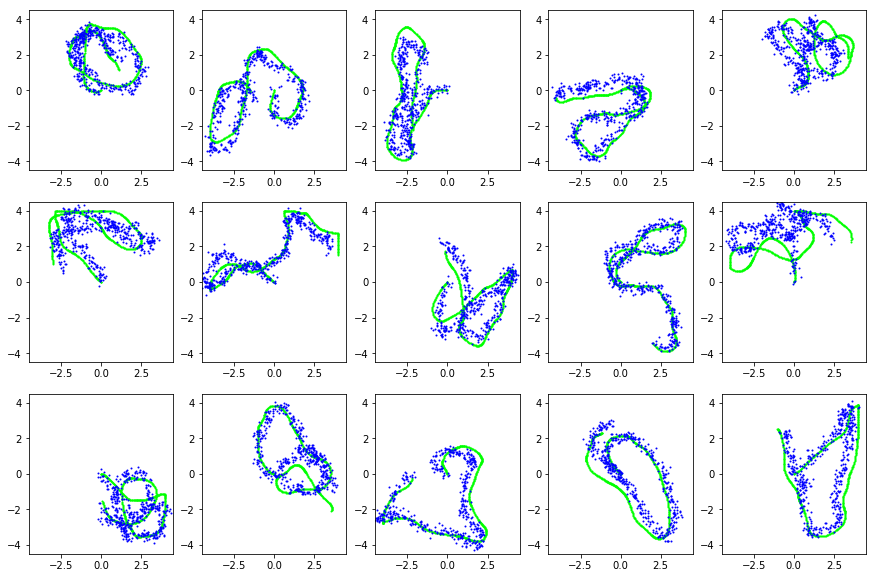

In [18]:
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_x = input_x[pointer*ep_length:(pointer+1)*ep_length]
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,x_size]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [1]}
    yp = sess.run(rat_rnn.y_pred, feed_dict=feed_dict) + batch_y[0]
    
    # Real - Green | Predicted - Blue
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.scatter(yp[:, 0], yp[:, 1], s=1, c=[0,0,1,1])
    plt.ylim(-4.5, 4.5)
    plt.xlim(-4.5, 4.5)
plt.show()

### Display neuron activation rates

In [16]:
resolution = 32
maze_extents = 4.5
rate = np.zeros([hidden_units, resolution, resolution])
count = np.zeros([resolution, resolution])
for i in range(min(5000,len(input_x)//ep_length)):
    pointer = i
    batch_x = input_x[pointer*ep_length:(pointer+1)*ep_length]
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,x_size]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [1]}
    act = sess.run(rat_rnn.output, feed_dict=feed_dict)
    
    for j in range(ep_length):
        x = (batch_y[j][0] + maze_extents)/(maze_extents*2) * resolution
        y = (batch_y[j][1] + maze_extents)/(maze_extents*2) * resolution
        count[int(x), int(y)] += 1
        rate[:, int(x), int(y)] += np.abs(act[j, :])
                      
for x in range(resolution):
    for y in range(resolution):
        if count[x, y] > 0:
            rate[:, x, y] /= count[x, y]

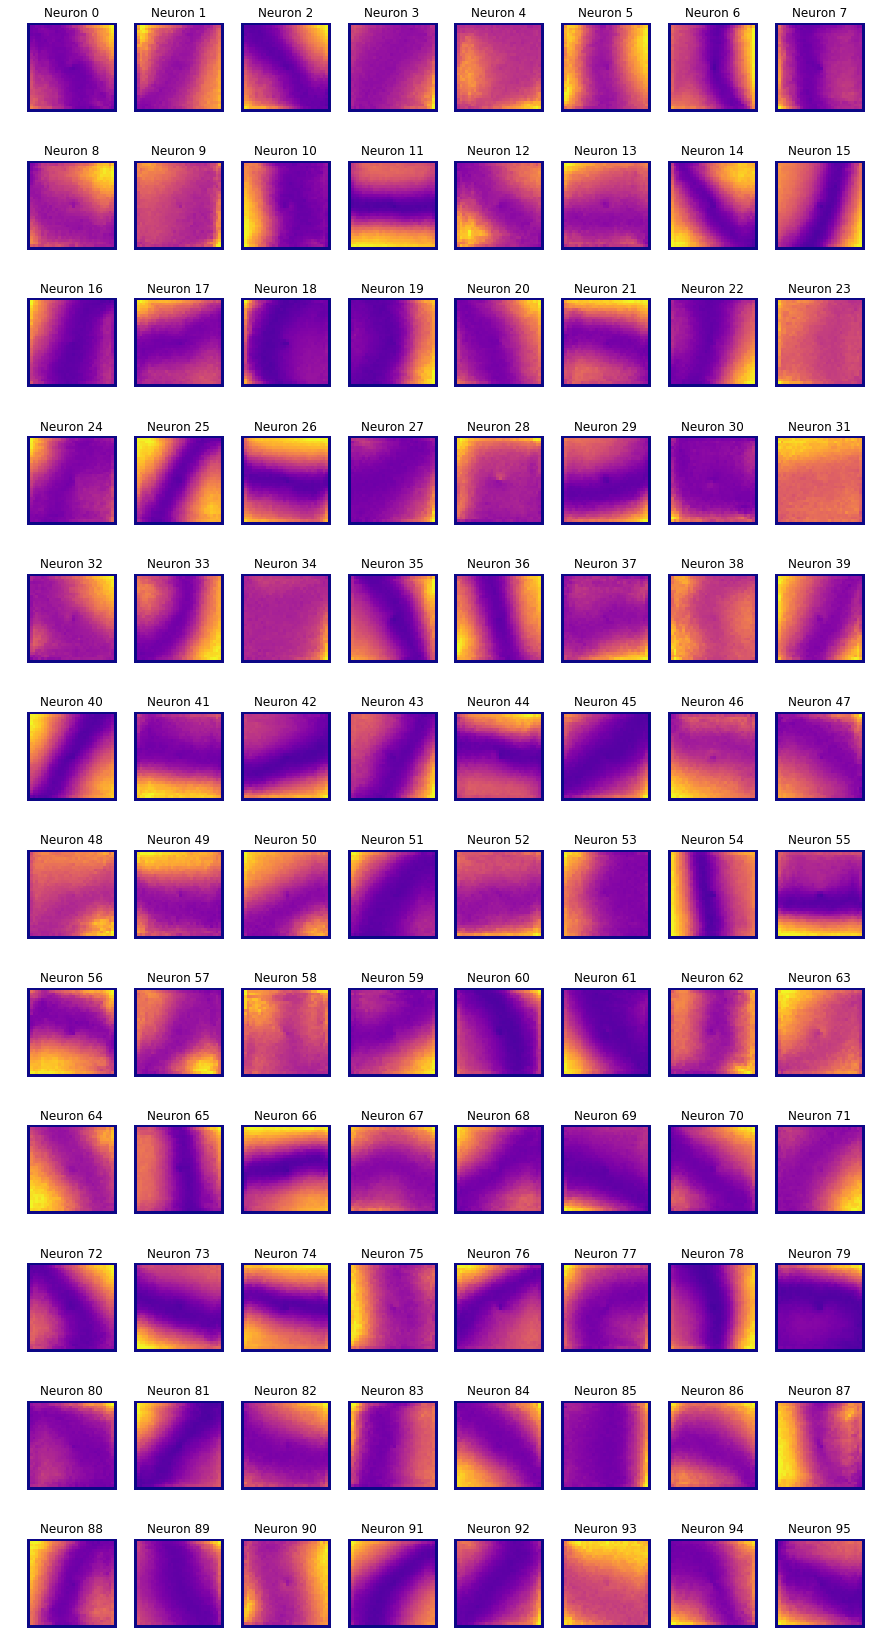

In [17]:
            
plt.figure(figsize=(15,30))
for h in range(hidden_units):
    plt.subplot(hidden_units//8, 8, 1 + h)
    plt.title('Neuron ' + str(h))
    plt.imshow(rate[h,:,:] / np.max(rate[h,:,:]), interpolation="nearest", cmap="plasma")
    plt.axis('off')
    
plt.show()

### Close TensorFlow Session & Environment

In [ ]:
sess.close()
env.close()

In [ ]:
print(input_Y)
print(input_y)

In [ ]:
plt.figure(figsize=(15,30))
for h in range(hidden_units):
    plt.subplot(hidden_units//8, 8, 1 + h)
    plt.title('Neuron ' + str(h))
    #plt.imshow(rate[h,:,:] / np.max(rate[h,:,:]), interpolation="nearest", cmap="plasma")
    plt.imshow(np.minimum(rate[h,:,:], np.max(rate[h,:,:]) * .5), interpolation="nearest", cmap="plasma")
    plt.axis('off')
    
plt.show()